In [1]:
import os
import sys

import matplotlib.pyplot as plt

import numpy as np
import torch
import pandas as pd
from train.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
ntrain = 250
sub = 1
dataset_dir = '/mountvol2/2D-1024-Dataset-0/' #Change directory based on actual location
Sx = Sy = int(((1024 - 1) / sub) + 1)
maps = np.load(dataset_dir+'mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
# maps = maps[0,:,:].reshape(1,Sx,Sy)

Load Saved Start and Goal Positions

In [3]:
startpositions = np.load(dataset_dir+'startpositions.npy')
goalpositions = np.load(dataset_dir+'goalpositions.npy')

Comparing Euclidean Norm

In [5]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=True)



Testing Euclidean Norm
Average Path Cost: 530.5669347025112 
Average Planning Time: 4.372699489593506 
Average Number of Node Expansions: 54790.36 
Average Success Rate: 1.0


Planning Operator

In [4]:
# Model
modes = 8
width = 28
nlayers = 1

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load(dataset_dir+"planningoperator_street_maps_1024x1024_8m_28w_1l_b5/n500_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model1024.ckpt")) #Change directory based on actual location
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_6309/3860456090.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dataset_dir+"planningoperator_street_maps_1024x1024_8m_28

PlanningOperator2D(
  (fc0): Linear(in_features=2, out_features=28, bias=True)
  (conv0): SpectralConv2d()
  (w0): Conv2d(28, 28, kernel_size=(1, 1), stride=(1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=28, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

No Erosion

In [7]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 1, model=model)

Testing PNO
Average Path Cost: 614.4032420477947 
Average Planning Time: 2.502922282218933 
Average Inference Time: 0.19311603546142578 
Average Number of Node Expansions: 39438.96 
Average Success Rate: 1.0


With Erosion

In [9]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 18, model=model)

Testing PNO
Average Path Cost: 608.5468163587987 
Average Planning Time: 2.700401005744934 
Average Inference Time: 0.190843825340271 
Average Number of Node Expansions: 41949.08 
Average Success Rate: 1.0


100%|██████████| 14/14 [12:16<00:00, 52.58s/it]


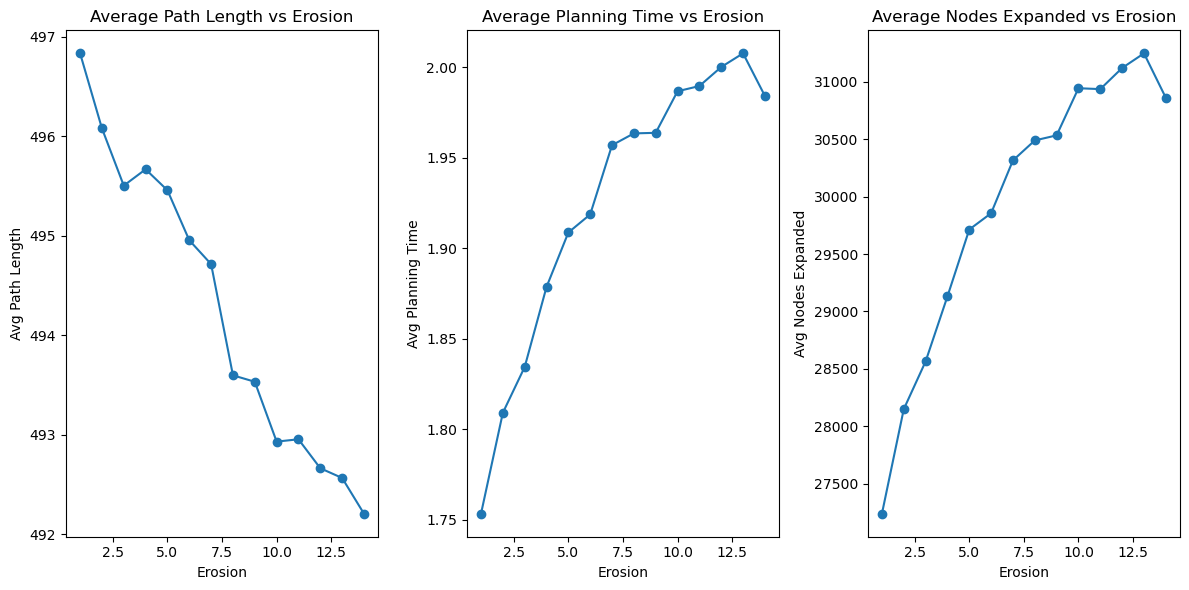

In [15]:

from tqdm import tqdm 

erosionmaps = maps[::10, :, :]
erosionstartpos = startpositions[::10,:]
erosiongoalpos = goalpositions[::10,:]

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# Run the loop and store results
for erode in tqdm(range(1, 15)):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        erosionstartpos, erosiongoalpos, erosionmaps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

plt.figure(figsize=(12, 6))

# Plot for avgpathcost (Average Path Length)
plt.subplot(1, 3, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Length vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Length')

# Plot for avgplantime (Average Planning Time)
plt.subplot(1, 3, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avgnodesexp (Average Nodes Expanded)
plt.subplot(1, 3, 3)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

plt.tight_layout()
plt.show()

Test Single Maps

Plotting Euclidean Norm
Average Path Cost: 673.5290039756352 
Average Planning Time: 7.020047664642334 
Average Number of Node Expansions: 86179.0 
Average Success Rate: 1.0


(673.5290039756352, 7.020047664642334, 0, 86179.0, 1.0)

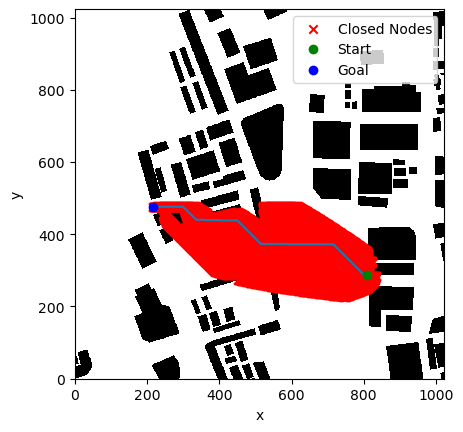

In [5]:
maptest = maps[0,:,:].reshape(1,Sx,Sy)
starttest = generaterandompos(maptest)
goaltest = generaterandompos(maptest)
print("Plotting Euclidean Norm")
testheuristiconmaps(starttest, goaltest, maptest, euclideannorm, plotresults=True, printvalues=True)

In [ ]:
print("Plotting PNO")
testheuristiconmaps(starttest, goaltest, maptest, planningoperator, plotresults=True, printvalues=True, erosion = 5, model=model)